# Exploration

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from PIL import Image
import cv2
import ast

ModuleNotFoundError: No module named 'matplotlib'

In [4]:
import numpy as np
np.zeros((156816, 36, 53806), dtype='uint8')

MemoryError: Unable to allocate 283. GiB for an array with shape (156816, 36, 53806) and data type uint8

## Train Study Level

...the train study-level metadata, with one row for each study, including correct labels.

The csv file is arranged as follows:

<code>id - unique study identifier
Negative for Pneumonia - 1 if the study is negative for pneumonia, 0 otherwise
Typical Appearance - 1 if the study has this appearance, 0 otherwise
Indeterminate Appearance  - 1 if the study has this appearance, 0 otherwise
Atypical Appearance  - 1 if the study has this appearance, 0 otherwise</code>

In [2]:
# import csv
train_study = pd.read_csv('../input/train_study_level.csv')

In [3]:
# csv info
train_study.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        6054 non-null   object
 1   Negative for Pneumonia    6054 non-null   int64 
 2   Typical Appearance        6054 non-null   int64 
 3   Indeterminate Appearance  6054 non-null   int64 
 4   Atypical Appearance       6054 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 236.6+ KB


In [4]:
# head of csv
train_study.head(10)

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1
5,00792b5c8852_study,1,0,0,0
6,00908ffd2d08_study,1,0,0,0
7,009bc005edaa_study,0,0,1,0
8,00a76543ed93_study,0,0,1,0
9,00a87235ca36_study,0,1,0,0


In [5]:
# correlation
corr = train_study.corr()

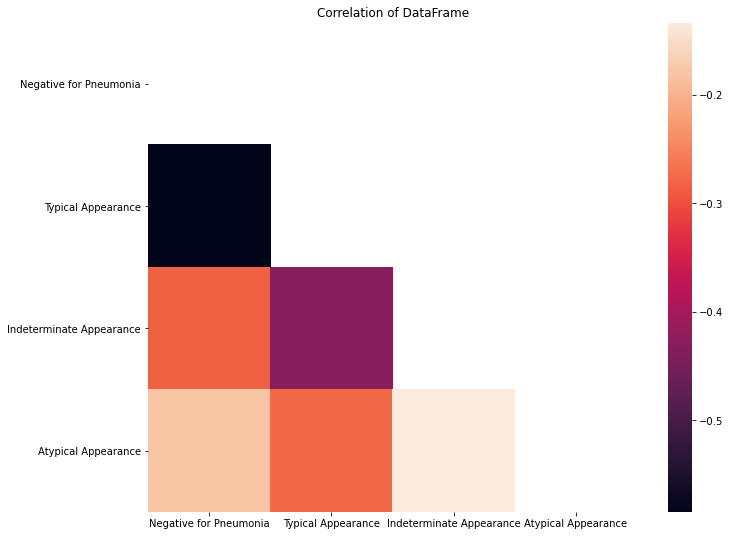

In [6]:
# seaborn plot

# generate mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# set up matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# draw heatmap with mask
sns.heatmap(corr, mask=mask, square=True).set(title='Correlation of DataFrame')

# display plot
plt.show()

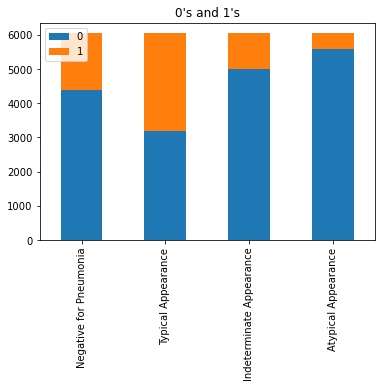

In [7]:
# counts for 0's and 1's
pneumonia = train_study['Negative for Pneumonia'].value_counts()
typical = train_study['Typical Appearance'].value_counts()
indeterminate = train_study['Indeterminate Appearance'].value_counts()
atypical = train_study['Atypical Appearance'].value_counts()

bar_chart = pd.DataFrame([pneumonia, typical, indeterminate, atypical])
bar_chart.plot(kind='bar', stacked=True, title="0's and 1's")
plt.show()


Clearly we have some class imbalance, roll in the focal loss.

## DCM Sample

[Kaggle Thread about DCM](https://www.kaggle.com/mujinjo/siim-covid-19-how-to-convert-dcm-to-image)

[How to use pydicom](https://pydicom.github.io/pydicom/stable/auto_examples/index.html)

In [8]:
# read files
file_path = '../input/train_study_samples/00086460a852/9e8302230c91/65761e66de9f.dcm'
DCM = pydicom.dcmread(file_path)

In [9]:
arr = DCM.pixel_array

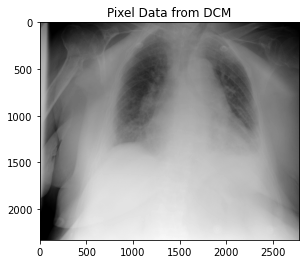

In [10]:
plt.imshow(arr, cmap='gray')
plt.title('Pixel Data from DCM')
plt.show()

## Header Data

In [11]:
def myprint(dataset, indent=0):
    """Go through all items in the dataset and print them with custom format

    Modelled after Dataset._pretty_str()
    """
    dont_print = ['Pixel Data', 'File Meta Information Version']

    indent_string = "   " * indent
    next_indent_string = "   " * (indent + 1)

    for data_element in dataset:
        if data_element.VR == "SQ":   # a sequence
            print(indent_string, data_element.name)
            for sequence_item in data_element.value:
                myprint(sequence_item, indent + 1)
                print(next_indent_string + "---------")
        else:
            if data_element.name in dont_print:
                print("""<item not printed -- in the "don't print" list>""")
            else:
                repr_value = repr(data_element.value)
                if len(repr_value) > 50:
                    repr_value = repr_value[:50] + "..."
                print("{0:s} {1:s} = {2:s}".format(indent_string,
                                                   data_element.name,
                                                   repr_value))

myprint(DCM)

 Specific Character Set = 'ISO_IR 100'
 Image Type = ['ORIGINAL', 'PRIMARY', '']
 SOP Class UID = '71228e4340de'
 SOP Instance UID = '65761e66de9f'
 Study Date = '4545ba78b753'
 Study Time = 'bf1677526b2b'
 Accession Number = '5f20f119e3df'
 Modality = 'DX'
 Private Creator = 'GEIIS'
 Patient's Name = 'd47cea7a3b93'
 Patient ID = '7d3bf0aef747'
 Patient's Sex = 'F'
 De-identification Method = 'CTP Default:  based on DICOM PS3.15 AnnexE. Detai...
 De-identification Method Code Sequence
    Code Value = '113100'
    Coding Scheme Designator = 'DCM'
    Code Meaning = 'Basic Application Confidentiality Profile'
   ---------
    Code Value = '113105'
    Coding Scheme Designator = 'DCM'
    Code Meaning = 'Clean Descriptors Option'
   ---------
    Code Value = '113107'
    Coding Scheme Designator = 'DCM'
    Code Meaning = 'Retain Longitudinal Temporal Information Modified...
   ---------
    Code Value = '113108'
    Coding Scheme Designator = 'DCM'
    Code Meaning = 'Retain Patient Ch

## Train Image Level

train_image_level.csv

<code>id - unique image identifier
boxes - bounding boxes in easily-readable dictionary format
label - the correct prediction label for the provided bounding boxes</code>

In [12]:
# import csv
train_image = pd.read_csv('../input/train_image_level.csv')

In [13]:
# info csv
train_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                6334 non-null   object
 1   boxes             4294 non-null   object
 2   label             6334 non-null   object
 3   StudyInstanceUID  6334 non-null   object
dtypes: object(4)
memory usage: 198.1+ KB


In [14]:
# head of csv
train_image.head(5)

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


## Back to DCM

There are some better ways to look at x-ray images and also storing the data contained in the header.

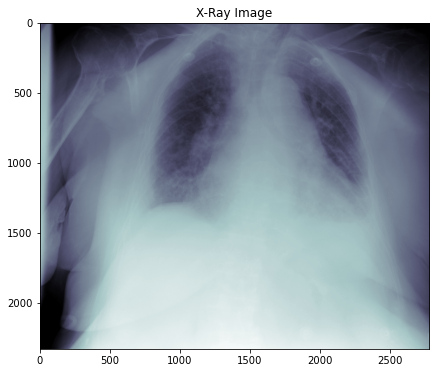

Patient ID.......: 7d3bf0aef747
Modality.........: DX
Study Date.......: 4545ba78b753
Image size.......: 2330 x 2783


In [15]:
# plot
fig, ax = plt.subplots(figsize=(15, 6))
plt.title('X-Ray Image')
plt.imshow(DCM.pixel_array, cmap=plt.cm.bone)
plt.show()

# data from header
print(f"Patient ID.......: {DCM.PatientID}")
print(f"Modality.........: {DCM.Modality}")
print(f"Study Date.......: {DCM.StudyDate}")
print(f"Image size.......: {DCM.Rows} x {DCM.Columns}")

## Hounsfiled Unit (HU)

The Hounsfield unit (HU) scale is a linear transformation of the original linear attenuation coefficient measurement into one in which the radiodensity of distilled water at standard pressure and temperature (STP) is defined as zero Hounsfield units (HU), while the radiodensity of air at STP is defined as −1000 HU. In a voxel with average linear attenuation coefficient {\displaystyle \mu }\mu , the corresponding HU value is therefore given by:

$HU = 1000 x \frac{\mu - \mu_{water}}{\mu_{water}-\mu_{air}}$


Thus, a change of one Hounsfield unit (HU) represents a change of 0.1% of the attenuation coefficient of water since the attenuation coefficient of air is nearly zero. It is the definition for CT scanners that are calibrated with reference to water.


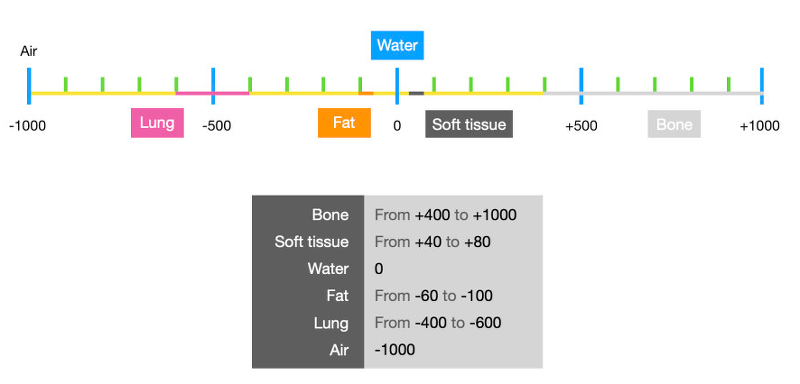


HU applies to medical-grade dual-energy CT scans but not to cone beam computed tomography (CBCT) scans. Values reported here are approximations. Different dynamics are reported from one study to another. Exact HU dynamics can vary from one CT acquisition to another due to CT acquisition and reconstruction parameters (kV, filters, reconstruction algorithms, etc.). The use of contrast agents modifies HU as well in some body parts (mainly blood).

HU Table url : https://en.wikipedia.org/wiki/Hounsfield_scale

^^ Lifted from [Kaggle Thread about DCM](https://www.kaggle.com/mujinjo/siim-covid-19-how-to-convert-dcm-to-image)

apply_voi_lut
reference url : https://www.kaggle.com/tanlikesmath/siim-covid-19-detection-a-simple-eda

In [16]:
# applying vio lut
def dicom2array(dicom, voi_lut=True, fix_monochrome=True):
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

data = dicom2array(DCM)

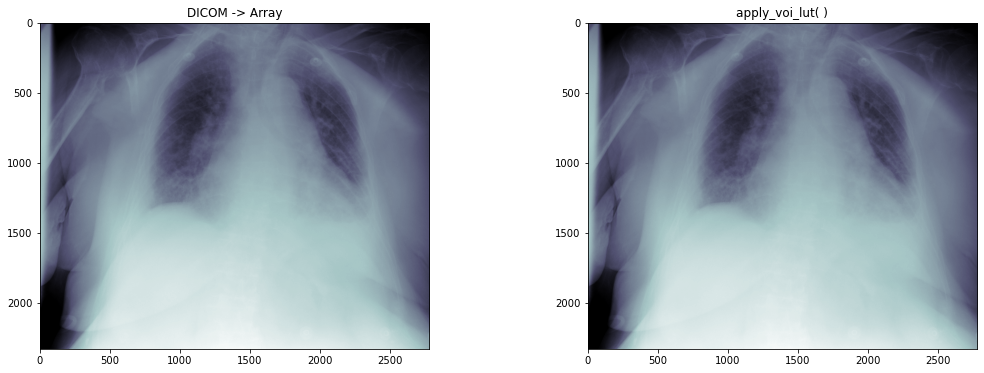

In [17]:
# comparing
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].imshow(DCM.pixel_array, cmap=plt.cm.bone)
ax[0].set_title('DICOM -> Array')
ax[1].imshow(data, cmap=plt.cm.bone)
ax[1].set_title('apply_voi_lut( )')

plt.show()

Can't get this to work!

## Bounding Boxes

Drawing bounding boxes around, things...

[Using ast for boxes](https://www.kaggle.com/shanmukh05/siim-covid-19-data-visualization)

Need to sort out using ast module to read string type boxes.

In [18]:
subject = train_image[train_image.StudyInstanceUID=='00086460a852'].copy()

In [19]:
subject.reset_index(inplace=True)

In [20]:
boxes = ast.literal_eval(subject.loc[0, 'boxes'])

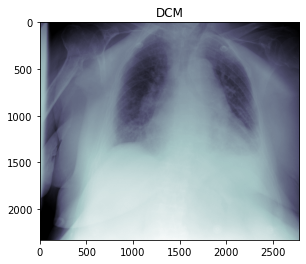

Boxes of: [{'x': 720.65215, 'y': 636.51048, 'width': 332.19348, 'height': 648.12561}, {'x': 2044.77989, 'y': 847.90622, 'width': 329.87049, 'height': 576.11169}]


In [21]:
plt.figure(12)
plt.imshow(arr, cmap=plt.cm.bone)
plt.title('DCM')
plt.show()
print('Boxes of: {}'.format(boxes))

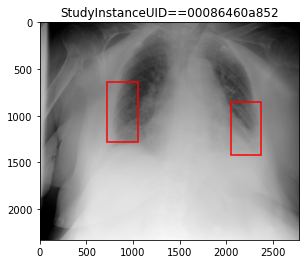

In [47]:
# draw boxes
fig, ax = plt.subplots(1,1, figsize=(8,4))
for box in boxes:
    p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                      box['width'], box['height'],
                                      ec='r', fc='none', lw=1.5)
    ax.add_patch(p)
ax.imshow(arr, cmap='gray')
plt.title('StudyInstanceUID==00086460a852')
plt.show()

# Merge Datasets

We want to merge train_study and train_image. 

StudyInstanceUID in train_image, is equal to id in train_study.

In [23]:
# check for null
train_study['id'].isnull().sum()

0

In [24]:
# split and extract id
train_study['id'] = train_study['id'].str.split('_').apply(lambda x: x[0])

In [25]:
# rename for merging
train_study = train_study.rename({'id':'StudyInstanceUID'}, axis=1)

In [26]:
# merge datasets
train = pd.merge(train_image, train_study, on='StudyInstanceUID')

## More Exploration

In [27]:
train

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0
...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,1,0,0,0
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,1,0,0,0
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0


In [28]:
OpacityCount = train['label'].str.count('opacity')

In [29]:
OpacityCount

0       2
1       0
2       2
3       1
4       2
       ..
6329    0
6330    0
6331    3
6332    2
6333    2
Name: label, Length: 6334, dtype: int64

## Study-Level Labels


So, the studies can have more than one label from the following labels:

<code>'negative', 'typical', 'indeterminate', 'atypical'</code>

And we need to predict from at least one of these labels for each study in the test set. The format for the <code>PredictionString</code> would be <code>negative 1 0 0 1 1</code> for single label and <code>indeterminate 1 0 0 1 1</code> <code>atypical 1 0 0 1 1</code> for multi-label.

<code>negative</code> being the label or class ID (one of the four labels), followed by <code>1</code> which is a confidence score and followed by <code>0 0 1 1</code> which is a one-pixel bounding box.

The bounding box will always be <code>0 0 1 1</code> irrespective of the label because we are using same submission file for both classification and object detection tasks and this format is used so that the evaluation metric (mAP) does not get affected by the classification task.

<code>In this competition, we are making predictions at both a study (multi-image) and image level.</code>

A study can have multiple images, this is based on the above statement and you can also observe this once you join <code>train_study_level.csv</code> and <code>train_image_level.csv</code>.

## Image-Level Labels

So, the images can have multiple objects in them and we must find the bounding boxes of these objects.

And the format for <code>PredictionString</code> would be <code>opacity 0.5 100 100 200 200</code> for image with single object and <code>opacity 0.5 100 100 200 200</code> <code>opacity 0.7 10 10 20 20 etc</code> for image with multiple objects.

<code>opacity</code> being the class ID, followed by <code>1</code> which is a confidence score and followed by <code>100 100 200 200</code> which is a bounding box in the format <code>xmin ymin xmax ymax</code>.

Suppose, if you predict that there are **NO objects** in the image, then the <code>PredictionString</code> would be <code>none 1 0 0 1 1</code>.

<code>none</code> is the class ID for *No Finding*, followed by <code>1</code> which is a <code>confidence</code> score and followed by <code>0 0 1 1</code> which is a one-pixel bounding box.

And each image has only one label from **'negative', 'typical', 'indeterminate', 'atypical'**. Thanks @awsaf49 for bringing this up.


[Lifted from](https://www.kaggle.com/c/siim-covid19-detection/discussion/240329#1314661)

In [30]:
# opacity count
train['OpacityCount'] = OpacityCount.values

### Opacity Count

As far as I am aware Opacity Count is the class ID, so <code>'negative', 'typical', 'indeterminate', 'atypical'</code>. But look into this as I am aware.

<AxesSubplot:title={'center':'Opacity Counts'}>

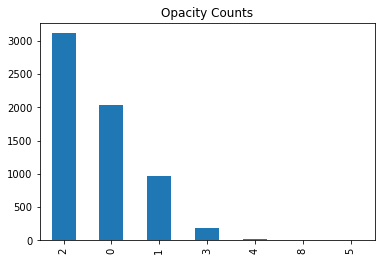

In [31]:
train.OpacityCount.value_counts().plot(kind='bar', title='Opacity Counts')

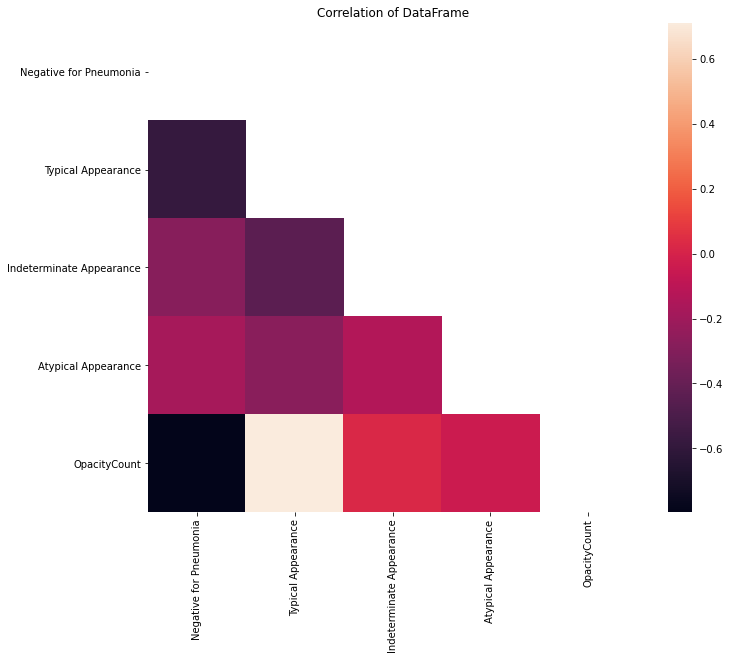

In [32]:
# seaborn plot
corr = train.corr()
# generate mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# set up matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# draw heatmap with mask
sns.heatmap(corr, mask=mask, square=True).set(title='Correlation of DataFrame')

# display plot
plt.show()

In [33]:
OCount = sorted(list(train['OpacityCount'].value_counts().index))
for count in OCount:
    print('Opacity Count = {}\n------------------------------'.format(count))
    print(train[train['OpacityCount'] == count].iloc[:,4:-1].sum())
    print(' ')

Opacity Count = 0
------------------------------
Negative for Pneumonia      1736
Typical Appearance           153
Indeterminate Appearance      59
Atypical Appearance           92
dtype: int64
 
Opacity Count = 1
------------------------------
Negative for Pneumonia        0
Typical Appearance           27
Indeterminate Appearance    685
Atypical Appearance         261
dtype: int64
 
Opacity Count = 2
------------------------------
Negative for Pneumonia         0
Typical Appearance          2653
Indeterminate Appearance     345
Atypical Appearance          115
dtype: int64
 
Opacity Count = 3
------------------------------
Negative for Pneumonia        0
Typical Appearance          152
Indeterminate Appearance     17
Atypical Appearance          14
dtype: int64
 
Opacity Count = 4
------------------------------
Negative for Pneumonia       0
Typical Appearance          21
Indeterminate Appearance     1
Atypical Appearance          1
dtype: int64
 
Opacity Count = 5
------------------

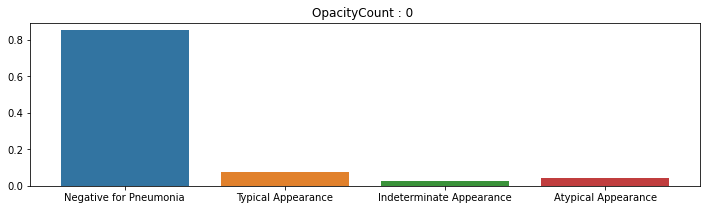

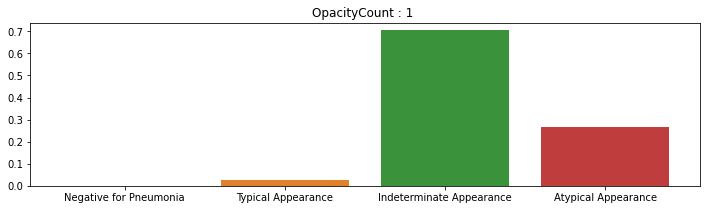

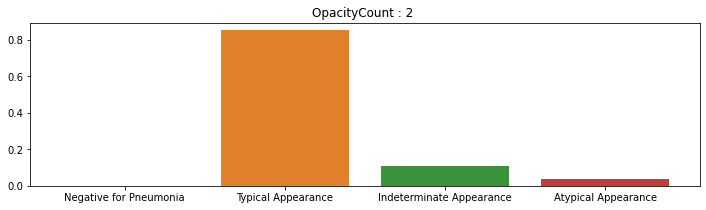

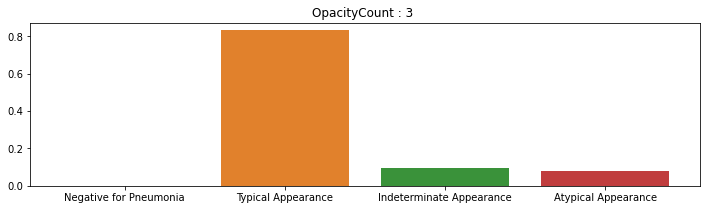

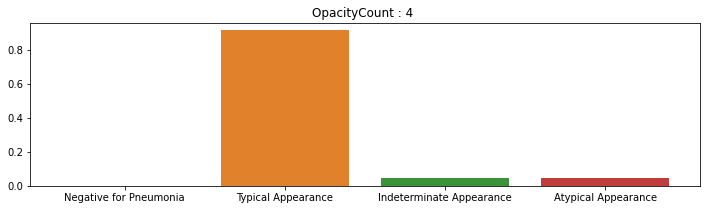

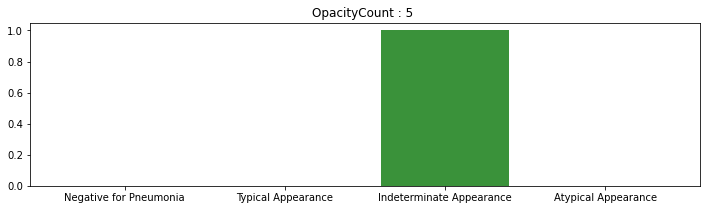

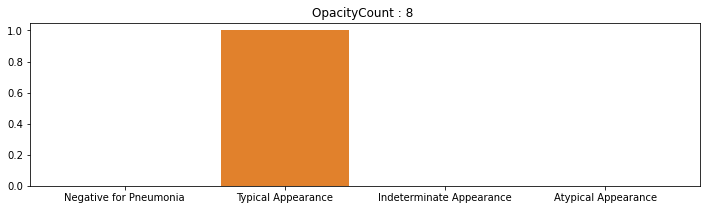

In [34]:
for count in OCount:
    Count_Series = train[train['OpacityCount'] == count].iloc[:,4:-1].sum()
    fig = plt.figure(figsize=(12,3))
    sns.barplot(x=Count_Series.index, y=Count_Series.values/sum(train['OpacityCount']==count))
    plt.title('OpacityCount : {} '.format(count))
    plt.plot();

## Seperate Bounding Boxes

In [35]:
testbox = train.loc[0, 'boxes']

In [36]:
ast.literal_eval(testbox)

[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292},
 {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]

In [37]:
df = train.dropna().copy()

In [38]:
df['boxes'] = df.boxes.apply(lambda x: ast.literal_eval(x))

In [39]:
df.explode('boxes')

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount
0,000a312787f2_image,"{'x': 789.28836, 'y': 582.43035, 'width': 1026...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2
0,000a312787f2_image,"{'x': 2245.91208, 'y': 591.20528, 'width': 109...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2
2,0012ff7358bc_image,"{'x': 677.42216, 'y': 197.97662, 'width': 867....",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2
2,0012ff7358bc_image,"{'x': 1792.69064, 'y': 402.5525, 'width': 617....",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2
3,001398f4ff4f_image,"{'x': 2729, 'y': 2181.33331, 'width': 948.0001...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...
6331,ffd9b6cf2961_image,"{'x': 707.25199, 'y': 722.07926, 'width': 392....",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0,3
6332,ffdc682f7680_image,"{'x': 2729.27083, 'y': 332.26044, 'width': 149...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0,2
6332,ffdc682f7680_image,"{'x': 1005.8125, 'y': 1584.67711, 'width': 662...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0,2
6333,ffe942c8655f_image,"{'x': 208.86463, 'y': 91.53448, 'width': 450.9...",opacity 1 208.86463 91.53448 659.8321 719.5892...,7d82d53204b8,0,1,0,0,2


In [40]:
df = df.explode('boxes')

In [41]:
df = df.reset_index(drop=True)

In [42]:
df['x'] = df.boxes.apply(lambda x: x['x'])
df['y'] = df.boxes.apply(lambda x: x['y'])
df['width'] = df.boxes.apply(lambda x: x['width'])
df['height'] = df.boxes.apply(lambda x: x['height'])

In [43]:
df.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount,x,y,width,height
0,000a312787f2_image,"{'x': 789.28836, 'y': 582.43035, 'width': 1026...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,789.28836,582.43035,1026.65662,1917.30292
1,000a312787f2_image,"{'x': 2245.91208, 'y': 591.20528, 'width': 109...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,2245.91208,591.20528,1094.66162,1761.54944
2,0012ff7358bc_image,"{'x': 677.42216, 'y': 197.97662, 'width': 867....",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,677.42216,197.97662,867.79767,999.78214
3,0012ff7358bc_image,"{'x': 1792.69064, 'y': 402.5525, 'width': 617....",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1792.69064,402.55250,617.02734,1204.35800
4,001398f4ff4f_image,"{'x': 2729, 'y': 2181.33331, 'width': 948.0001...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,2729.00000,2181.33331,948.00012,604.00000


# To Do:

- Split boxes up into more rows
- Check for duplicates
- Check for anomalies and errors
- Average BBOX location for classes (centres)
- Average BBOX stats (widths and heights)
- Feature engineering for data header within x-ray files

In [44]:
train.to_csv('../input/train.csv', index=False)

In [45]:
df.to_csv('../input/train_bbox.csv', index=False)